In [166]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import copy
import time

In [2]:
class Actor(nn.Module):
    
    def __init__(self, obs_dim, act_dim, hidden_size = 64):
        '''
        Initializing a 2 layer neural net
        '''
        super(Actor, self).__init__()
        self.policy = nn.Sequential(
                        nn.Linear(obs_dim, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, act_dim),
                        nn.Softmax(dim = -1)
                    )
        
    def forward(self, x):
        '''
        Input:
            -x : A tensor of shape [batch_size, obs_dim] representing the state
        
        Returns a tensor of shape [batch_size, act_dim] representing the probability of taking each action
        '''
        return self.policy(x)

In [3]:
class Critic(nn.Module):
    
    def __init__(self, obs_dim, hidden_size = 64):
        '''
        Initializing a 2 layer neural net
        '''
        super(Critic, self).__init__()
        self.value = nn.Sequential(
                        nn.Linear(obs_dim, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, 1),
                    )
        
    def forward(self, x):
        '''
        Input:
            -x : A tensor of shape [batch_size, obs_dim] representing the state
        
        Returns a tensor of shape [batch_size, 1] representing the value function of input state
        '''
        return self.value(x)

In [121]:
env = gym.make('CartPole-v0')

In [122]:
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n

In [150]:
net_act = Actor(obs_dim, act_dim)

In [151]:
net_crt = Critic(obs_dim)

In [152]:
net_act

Actor(
  (policy): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
    (3): Softmax()
  )
)

In [153]:
net_crt

Critic(
  (value): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [154]:
opti_act = optim.Adam(net_act.parameters(), lr = 0.01)

In [155]:
opti_crt = optim.Adam(net_crt.parameters(), lr = 0.01)

In [193]:
def find_q_vals(rewards, last_q_val, gamma):
    
    '''
    
    Computes the q values using the finite horizon method as we saw in the slides
    
    Inputs:
        - rewards : A tensor containing rewards for T time steps
        - last_val : Value function of the last state
        - gamma : discount factor
    '''
    
    q_vals = torch.zeros_like(rewards)
    q_vals[-1] = last_val.squeeze()
    
    for t in reversed(range(len(rewards)-1)):
        q_vals[t] = rewards[t] + gamma * q_vals[t+1]
        
    return q_vals

In [194]:
def an_actors_life(env, net_act, net_crt, init_state, gamma =0.99, T = 20):
    
    '''
    Actor interacts with environment for T steps, then computes the policy and value gradients and store them
    
    Inputs:
        - env : Gym environment
        - net_act : Actor network
        - net_crt : Critic network
        - init_state : Initial state to start the trajectory from
        - gamma : discount factor
        - T : Horizon length
    '''
    
    states = []
    logps = []
    rewards = []
    state = init_state
    
    #Play the game for T steps
    for i in range(T):
        states.append(state)
        state_v = torch.FloatTensor([state])
        p_v = net_act(state_v)
        p = p_v.detach().numpy().squeeze()
        action = np.random.choice(np.arange(act_dim), p = p)
        state, reward, done, _ = env.step(action)
        rewards.append(reward)
        logps.append(torch.log(p_v)[:1, action])
        
        if done:
            state = env.reset()
            break
    
    #Converting states, logps and rewards to torch tensors
    states_v = torch.FloatTensor(states)
    logps_v = torch.cat(logps, dim = 0)
    rewards_v = torch.FloatTensor(rewards)
    
    #Defining the value function corresponding to the final state
    if done:
        last_val = torch.FloatTensor([0])
    else:
        last_val = net_crt(states_v[-1:])
    
    #Compute advantages
    q_vals = find_q_vals(rewards_v, last_val, gamma).detach()
    vals = net_crt(states_v)
    advs = (q_vals - vals.squeeze()).detach()
    
    #Accumulate the gradients for critic
    loss_crt = ((q_vals - vals.squeeze())**2).mean()
    loss_crt.backward()
    
    #Accumulate the gradients of actor
    loss_act = (-logps_v * advs).mean()
    loss_act.backward()
    
    return env, state
    

In [195]:
def test(env, net_act):
    
    state = env.reset()
    tot_reward = 0
    while True:
        state_v = torch.FloatTensor(state).unsqueeze(0)
        p_v = net_act(state_v)
        p = p_v.detach().numpy().squeeze()
        action = np.random.choice(np.arange(act_dim), p = p)
        state, reward, done, _ = env.step(action)

        tot_reward += reward
        if done:
            break
            
    return tot_reward

In [159]:
def A2C(env, net_act, net_crt, opti_act, opti_crt, N_actrs = 10, T = 20, num_runs = 20000, gamma = 0.99, test_every = 1):
    
    
    running_return = 0
    running_returns = []
    ep = 0
    t = 0
    state = env.reset()
    states = []
    logps = []
    rewards = []
    
    #Allocate different environment for each actor
    envs = [copy.deepcopy(env) for _ in range(N_actrs)]
    states = [env.reset() for env in envs]
    for i in range(num_runs):
        
        net_act.zero_grad()
        net_crt.zero_grad()
        
        #All actors play their parts
        for n in range(N_actrs):
            env, state = an_actors_life(envs[n], net_act, net_crt, states[n])
            envs[n] = env
            states[n] = state
            
        #Update actor and critic    
        opti_crt.step()
        opti_act.step()
        
        if (i+1)%test_every == 0:
            tot_rewards = test(env, net_act)
            running_return = 0.1*tot_rewards + 0.9*running_return
            running_returns.append(running_return)
            
            print("Iteration {} Total reward {}, mean return {}".format(i+1, tot_rewards, np.round(running_return,2)))
            
    return running_returns

In [160]:
running_returns = A2C(env, net_act, net_crt, opti_act, opti_crt, num_runs = 200, N_actrs = 20, T = 20)

Iteration 1 Total reward 37.0, mean return 3.7
Iteration 2 Total reward 30.0, mean return 6.33
Iteration 3 Total reward 23.0, mean return 8.0
Iteration 4 Total reward 47.0, mean return 11.9
Iteration 5 Total reward 34.0, mean return 14.11
Iteration 6 Total reward 33.0, mean return 16.0
Iteration 7 Total reward 31.0, mean return 17.5
Iteration 8 Total reward 16.0, mean return 17.35
Iteration 9 Total reward 77.0, mean return 23.31
Iteration 10 Total reward 31.0, mean return 24.08
Iteration 11 Total reward 35.0, mean return 25.17
Iteration 12 Total reward 41.0, mean return 26.76
Iteration 13 Total reward 40.0, mean return 28.08
Iteration 14 Total reward 62.0, mean return 31.47
Iteration 15 Total reward 105.0, mean return 38.83
Iteration 16 Total reward 71.0, mean return 42.04
Iteration 17 Total reward 88.0, mean return 46.64
Iteration 18 Total reward 67.0, mean return 48.67
Iteration 19 Total reward 79.0, mean return 51.71
Iteration 20 Total reward 61.0, mean return 52.64
Iteration 21 Tot

Iteration 160 Total reward 200.0, mean return 169.94
Iteration 161 Total reward 200.0, mean return 172.95
Iteration 162 Total reward 200.0, mean return 175.65
Iteration 163 Total reward 200.0, mean return 178.09
Iteration 164 Total reward 200.0, mean return 180.28
Iteration 165 Total reward 200.0, mean return 182.25
Iteration 166 Total reward 200.0, mean return 184.02
Iteration 167 Total reward 138.0, mean return 179.42
Iteration 168 Total reward 200.0, mean return 181.48
Iteration 169 Total reward 169.0, mean return 180.23
Iteration 170 Total reward 146.0, mean return 176.81
Iteration 171 Total reward 200.0, mean return 179.13
Iteration 172 Total reward 200.0, mean return 181.22
Iteration 173 Total reward 200.0, mean return 183.09
Iteration 174 Total reward 200.0, mean return 184.78
Iteration 175 Total reward 200.0, mean return 186.31
Iteration 176 Total reward 200.0, mean return 187.68
Iteration 177 Total reward 200.0, mean return 188.91
Iteration 178 Total reward 200.0, mean return 

Text(0,0.5,'Training iterations')

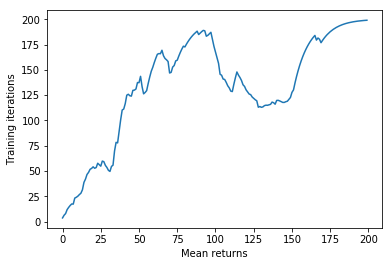

In [164]:
plt.plot(running_returns)
plt.xlabel("Mean returns")
plt.ylabel("Training iterations")

In [162]:
torch.save(net_act.state_dict(),'Policies/cart_pole.dat')

In [168]:
for i in range(1):
    state = env.reset()
    tot_reward = 0
    while True:
        env.render()
        time.sleep(.03)
        state_v = torch.FloatTensor(state).unsqueeze(0)
        p_v = net_act(state_v)
        p = p_v.detach().numpy().squeeze()
        action = np.argmax(p)
        state, reward, done, _ = env.step(action)
        tot_reward += reward
        if done:
            break
            
print(tot_reward)

200.0
